In [2]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

In [1]:
from torch.utils.tensorboard import SummaryWriter
tb_writer = SummaryWriter("runs/malayalam handwriting classification model - 2")

## Data Visualization and Pre - processing

In [6]:
# Load the image
image_path = 'data/character_3333/7.png'
image = Image.open(image_path)

In [7]:
# Convert the image to a NumPy array
image_array = np.array(image)

# Find the max and min pixel values
max_pixel_value = np.max(image_array)
min_pixel_value = np.min(image_array)
mean_pixel_value = np.mean(image_array)

print(f'Max pixel value: {max_pixel_value}')
print(f'Min pixel value: {min_pixel_value}')
print(f'Mean pixel value: {mean_pixel_value}')

Max pixel value: 255
Min pixel value: 0
Mean pixel value: 8.113805555555556


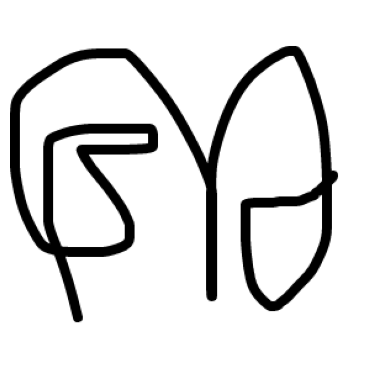

In [8]:
# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

### testing transform on 1 image

In [9]:
raw_transform = transforms.Compose([
    transforms.Resize((32, 32)),                    # Resize to 32x32 pixels
    transforms.ToTensor(),                          # Convert to PyTorch tensor
])

In [10]:
transformed_image = raw_transform(image)

In [11]:
# find max, mean and min pixel values
print("Tensor shape:", transformed_image.shape)
print("Min pixel value:", transformed_image.min().item())
print("Max pixel value:", transformed_image.max().item())
print("Mean pixel value:", transformed_image.mean().item())

Tensor shape: torch.Size([4, 32, 32])
Min pixel value: 0.0
Max pixel value: 0.8784313797950745
Mean pixel value: 0.03184359893202782


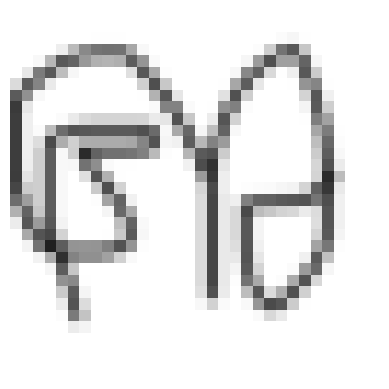

In [12]:
plt.imshow(transformed_image.permute(1, 2, 0).numpy().clip(0,1))
plt.axis("off")
plt.show()

### Checking the datsaset

In [20]:
# Path to a sample image
sample_img_path = "data/character_3333/3.png"

# Open the image
img = Image.open(sample_img_path)
print(f"Image mode: {img.mode}")  # Should be "RGB" or "RGBA"
print(f"Image size: {img.size}")

# Convert to NumPy array and inspect pixel values
img_array = np.array(img)
print(f"Pixel range: {img_array.min()} to {img_array.max()}")


Image mode: RGBA
Image size: (300, 300)
Pixel range: 0 to 255


In [21]:
# Load a single image from your dataset
image_path = "data/character_3367/1.png"  # Adjust this path based on your dataset
image = Image.open(image_path)

# Convert the image to a numpy array
image_np = np.array(image)

# Display the pixel values of the image
print(f"Min pixel value: {image_np.min()}")
print(f"Max pixel value: {image_np.max()}")
print(f"Mean pixel value: {image_np.mean()}")


Min pixel value: 0
Max pixel value: 255
Mean pixel value: 2.3319972222222223


### Creating a dictionary with image path as key and class as value

In [22]:
data_dir = 'data'  # Path to the root data directory containing subfolders
letter_dict = {"rgb_data/"+folder: idx for idx, folder in enumerate(os.listdir(data_dir))}
print(letter_dict)

{'rgb_data/character_3333': 0, 'rgb_data/character_3334': 1, 'rgb_data/character_3335': 2, 'rgb_data/character_3337': 3, 'rgb_data/character_3342': 4, 'rgb_data/character_3343': 5, 'rgb_data/character_3346': 6, 'rgb_data/character_3349': 7, 'rgb_data/character_3350': 8, 'rgb_data/character_3351': 9, 'rgb_data/character_3352': 10, 'rgb_data/character_3353': 11, 'rgb_data/character_3354': 12, 'rgb_data/character_3355': 13, 'rgb_data/character_3356': 14, 'rgb_data/character_3357': 15, 'rgb_data/character_3358': 16, 'rgb_data/character_3359': 17, 'rgb_data/character_3360': 18, 'rgb_data/character_3361': 19, 'rgb_data/character_3362': 20, 'rgb_data/character_3363': 21, 'rgb_data/character_3364': 22, 'rgb_data/character_3365': 23, 'rgb_data/character_3366': 24, 'rgb_data/character_3367': 25, 'rgb_data/character_3368': 26, 'rgb_data/character_3370': 27, 'rgb_data/character_3371': 28, 'rgb_data/character_3372': 29, 'rgb_data/character_3373': 30, 'rgb_data/character_3374': 31, 'rgb_data/charact

### Creating the Custom dataset loader

In [23]:
class MalHandwritingDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
            
        return (image, label)

### Converting RGBA images to RGB images

In [24]:
# from conversion import convert_rgba_to_rgb

# # Paths
# input_dir = "data"      # Original folder containing the class folders
# output_dir = "rgb_data"    # New folder to store the converted images

# # Create the output directory structure
# for root, dirs, files in os.walk(input_dir):
#     # Create corresponding directories in the output path
#     relative_path = os.path.relpath(root, input_dir)
#     target_path = os.path.join(output_dir, relative_path)
#     os.makedirs(target_path, exist_ok=True)
    
#     for file_name in files:
#         input_path = os.path.join(root, file_name)
#         output_path = os.path.join(target_path, file_name)
        
#         # Convert images to RGB
#         try:
#             convert_rgba_to_rgb(input_path, output_path)
#             print(f"Converted: {input_path} -> {output_path}")
#         except Exception as e:
#             print(f"Error processing {input_path}: {e}")


#### Creating labels.csv for newly converted files
- This is a csv file with all image paths and class labels stored next to each other, created from letter_dict dictionary

In [18]:
# creating data path
root_dir = "rgb_data"

# Dictionary to store image names and labels
image_label_dict = {}

# Iterate through all subdirectories and files
for label_name in os.listdir(root_dir):
    label_path = os.path.join(root_dir, label_name)
    
    # Ensure it's a directory
    if os.path.isdir(label_path):
        for file_name in os.listdir(label_path):
            # Check if the file is an image (optional: add more extensions if needed)
            if file_name.endswith('.png'):
                image_label_dict[label_name+"/"+file_name] = letter_dict["rgb_data"+"/"+label_name]

# Print the dictionary
for image, label in list(image_label_dict.items())[:10]:  # Display the first 10 entries
    print(f"Image: {image}, Label: {label}")

# Total number of entries
print(f"\nTotal images: {len(image_label_dict)}")


Image: character_3333/100.png, Label: 0
Image: character_3333/101.png, Label: 0
Image: character_3333/102.png, Label: 0
Image: character_3333/103.png, Label: 0
Image: character_3333/104.png, Label: 0
Image: character_3333/105.png, Label: 0
Image: character_3333/106.png, Label: 0
Image: character_3333/107.png, Label: 0
Image: character_3333/108.png, Label: 0
Image: character_3333/109.png, Label: 0

Total images: 6090


In [19]:
# import csv

# # Path to save the CSV file
# csv_file_path = "labels.csv"

# # Write the dictionary to a CSV file
# with open(csv_file_path, mode='w', newline='') as csv_file:
#     writer = csv.writer(csv_file)
#     writer.writerow(["Image Name", "Class Label"])  # Header row
#     for image_name, class_label in image_label_dict.items():
#         writer.writerow([image_name, class_label])

# print(f"CSV file saved at: {csv_file_path}")


#### The final transforms

In [25]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

### Loading the dataset and applying transforms

In [21]:
dataset = MalHandwritingDataset(csv_file="labels.csv",
                                root_dir=root_dir,
                                transform=transform)


### Train and test split

In [22]:
# Split dataset into training and testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)


In [23]:
# Check the first batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Batch size: {images.shape}")  # e.g., torch.Size([32, 3, 64, 64])
print(f"Labels: {labels}")
print(len(labels))


Batch size: torch.Size([32, 3, 32, 32])
Labels: tensor([ 6,  8, 47, 37, 31, 17, 38,  2, 15, 15, 25,  7, 30, 39, 45, 35, 33, 31,
        38,  7,  7, 41, 22,  1,  2, 13, 22, 17, 34, 13, 17, 13])
32


#### displaying pixel values

In [24]:
# Check the min and max pixel values
print(f'Min pixel value: {images[0][0].min().item()}')
print(f'Max pixel value: {images[0][0].max().item()}')
print(f"Mean Pixel Value: {images[0][0].mean().item()}")

Min pixel value: 0.2862745225429535
Max pixel value: 1.0
Mean Pixel Value: 0.9615923166275024


#### Visualizing one batch of images

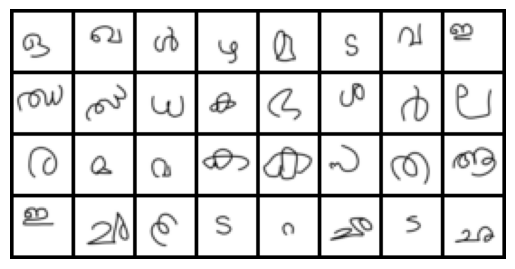

In [25]:
# Create a grid of images
img_grid = torchvision.utils.make_grid(images, nrow=8)  # 8 images per row

# Convert the grid to a NumPy array and transpose the dimensions
np_grid = img_grid.numpy().clip(0,1)

np_grid = np_grid.transpose((1, 2, 0))

# Display the grid of images
plt.imshow(np_grid)
plt.axis('off')  # Hide the axis
# Add the grid of images to TensorBoard
tb_writer.add_image("MalHandwriting", img_grid)
# Close the writer
tb_writer.close()


In [26]:
print(images.shape)

torch.Size([32, 3, 32, 32])


In [9]:
num_classes = len(os.listdir("rgb_data"))
print(num_classes)

48


## Model Architecture

In [10]:
# Hyper-parameters
num_epochs = 500
batch_size = 32
# 6000 images in dataset, 80% for training -> 4800 images so 4800/32 = 150 iterations per epoch
learning_rate = 0.0001

In [11]:
# implement the CNN

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.AvgPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.AvgPool2d(2, 2)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # 16 * 5 * 5 is the size of the input to the fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
    
    def forward(self, x):
        
        # first conv2d layer
        x = self.pool(F.relu(self.conv1(x)))

        # second conv2d layer
        x = self.pool(F.relu(self.conv2(x)))
        
        # flatten the tensor
        x = x.view(-1, 16 * 5 * 5)
        
        
        # first fully connected layer
        x = F.relu(self.fc1(x))
        
        
        # second fully connected layer  
        x = F.relu(self.fc2(x))
        
        
        # third fully connected layer
        x = self.fc3(x)
        # last is softmax layer but that is done by optimizer
        
        return x
        

In [12]:
model = ConvNet()

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
tb_writer.add_graph(model, images)
tb_writer.close()

In [33]:
n_total_steps = len(train_loader)
best_loss = np.inf

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (images, labels) in enumerate(train_loader):
        # original shape: [32,3,64,64] = 32,3,1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        
        
        # forward pass
        output = model(images)
        loss = criterion(output, labels)
        
        # backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Log the loss to TensorBoard
        tb_writer.add_scalar('Training Loss', loss.item(), epoch * n_total_steps + i)
    
        if i == n_total_steps//2:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item()}')
            # Save the model if the current val_loss is the lowest
        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(model.state_dict(), 'mal_model.pth')
        
    # Calculate and log average loss and accuracy for the epoch
    epoch_loss = running_loss / n_total_steps
    epoch_accuracy = 100 * correct / total
    tb_writer.add_scalar('Epoch Loss', epoch_loss, epoch)
    tb_writer.add_scalar('Epoch Accuracy', epoch_accuracy, epoch)
            
print('Finished Training')
tb_writer.close()

Epoch [1/500], Step [77/153], Loss: 3.862003803253174
Epoch [2/500], Step [77/153], Loss: 3.8525662422180176
Epoch [3/500], Step [77/153], Loss: 3.8422930240631104
Epoch [4/500], Step [77/153], Loss: 3.879108428955078
Epoch [5/500], Step [77/153], Loss: 3.831341505050659
Epoch [6/500], Step [77/153], Loss: 3.7273998260498047
Epoch [7/500], Step [77/153], Loss: 3.7493793964385986
Epoch [8/500], Step [77/153], Loss: 3.627817153930664
Epoch [9/500], Step [77/153], Loss: 3.4428672790527344
Epoch [10/500], Step [77/153], Loss: 3.0397684574127197
Epoch [11/500], Step [77/153], Loss: 2.8624966144561768
Epoch [12/500], Step [77/153], Loss: 2.578793525695801
Epoch [13/500], Step [77/153], Loss: 2.9833033084869385
Epoch [14/500], Step [77/153], Loss: 2.989375352859497
Epoch [15/500], Step [77/153], Loss: 2.613767147064209
Epoch [16/500], Step [77/153], Loss: 2.7074482440948486
Epoch [17/500], Step [77/153], Loss: 2.7501823902130127
Epoch [18/500], Step [77/153], Loss: 2.6439499855041504
Epoch [1

In [34]:
classes = [i for i in range(48)]
print(classes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


In [17]:
with torch.no_grad():
    n_samples = 0
    n_correct = 0
    n_class_correct = [0 for i in range(48)]  # 48 classes
    n_class_samples = [0 for i in range(48)]  # 48 classes

    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc:.2f} %')
    tb_writer.add_scalar('Accuracy/Overall', acc)

    for i in range(48):  # Iterate over the range of the number of classes
        if n_class_samples[i] > 0:
            class_acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {classes[i]}: {class_acc:.2f} %')
            tb_writer.add_scalar(f'Accuracy/{classes[i]}', class_acc)
        else:
            print(f'Accuracy of {classes[i]}: N/A (no samples)')

tb_writer.close()

NameError: name 'test_loader' is not defined

### Testing one one new prediction

In [35]:
import pandas as pd
df =pd.read_csv("labels.csv")
df.rename(columns={'Image Name': 'image', 'Class Label': 'label'}, inplace=True)
df.head()


,image,label
0,character_3333/100.png,0
1,character_3333/101.png,0
2,character_3333/102.png,0
3,character_3333/103.png,0
4,character_3333/104.png,0


In [41]:
unique_value = 'character_3375/3.png'

# Print the row where 'image' column has the unique value
row = df.loc[df['image'] == unique_value]
print(row)

                     image  label
4385  character_3375/3.png     32


In [46]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth'))
model.eval()  # Set the model to evaluation mode

unique_value = 'character_3333/3.png'

# Print the row where 'image' column has the unique value
row = df.loc[df['image'] == unique_value]
print(row)

# Load and transform the image
image = Image.open('rgb_data/character_3333/3.png')
transformed_image = transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")

                    image  label
133  character_3333/3.png      0
Predicted class: 0


In [47]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth'))
model.eval()  # Set the model to evaluation mode

unique_value = 'character_3375/3.png'

# Print the row where 'image' column has the unique value
row = df.loc[df['image'] == unique_value]
print(row)

# Load and transform the image
image = Image.open('rgb_data/character_3375/3.png')
transformed_image = transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")

                     image  label
4385  character_3375/3.png     32
Predicted class: 32


In [98]:
unique_value = 'character_3374/8.png'

# Print the row where 'image' column has the unique value
row = df.loc[df['image'] == unique_value]
print(row)

                     image  label
4322  character_3374/8.png     31


In [100]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth'))
model.eval()  # Set the model to evaluation mode

unique_value = 'character_3374/8.png'

# Print the row where 'image' column has the unique value
row = df.loc[df['image'] == unique_value]
print(row)

# Load and transform the image
image = Image.open('rgb_data/character_3374/8.png')
transformed_image = transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")

                     image  label
4322  character_3374/8.png     31
Predicted class: 31


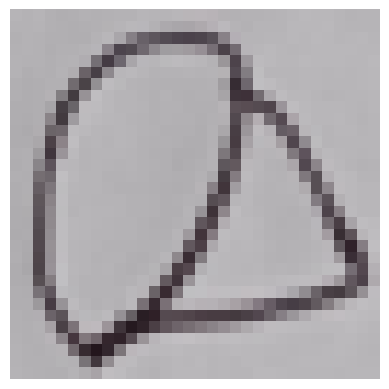

Predicted class: 2


In [97]:
# Load and transform the image
image = Image.open('robby_maaaaa.jpeg')

# defining transform
crop_box = (340, 215, 950, 475)  # Example values, adjust as needed

# Define the transformations
crop_transform = transforms.Compose([
    #transforms.Lambda(lambda img: img.crop(crop_box)),  # Crop the image
    transforms.Resize((32, 32)),  # Resize to 64x64 pixels
    transforms.ToTensor()  # Convert to PyTorch tensor
])
crop_transformed_image = crop_transform(image)
plt.imshow(crop_transformed_image.permute(1, 2, 0).numpy().clip(0,1))
plt.axis("off")
plt.show()
crop_transformed_image = crop_transformed_image.unsqueeze(0)  # Add a batch dimension


# Pass the input through the model
with torch.no_grad():
    output = model(crop_transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")